In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Notebooks/hate_speech/

/content/drive/MyDrive/Notebooks/hate_speech


# Hate Speech Project
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#h">Hypothesis Generation</a></li>
<li><a href="#i">Import Packages and Loading Data</a></li>
<li><a href="#eda">Featurization</a></li>


</ul>

<a id='intro'></a>
## Introduction

### Project Description 
The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. In this problem, We will take you through a hate speech detection model with Machine Learning and Python.

Hate Speech Detection is generally a task of sentiment classification. So for training, a model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, We will use the Twitter tweets to identify tweets containing  Hate speech.

In [ ]:
!pip3 uninstall --yes torch  torchtext 
!pip3 install torch torchtext

Found existing installation: torch 1.13.1+cu116
Uninstalling torch-1.13.1+cu116:
  Successfully uninstalled torch-1.13.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 54.2 MB/s eta 0:00:00
     ━━

In [ ]:
!pip3 install torchtext==0.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [11]:
import numpy as np 
import pandas as pd
import spacy
from torch import nn
import torch
from torchtext import data
from torch.nn  import functional as F
import torch.optim as  optim 
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print("Train shape:",train.shape)
print("Test shape:",test.shape)

Train shape: (31962, 3)
Test shape: (17197, 2)


In [6]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## **EDA**

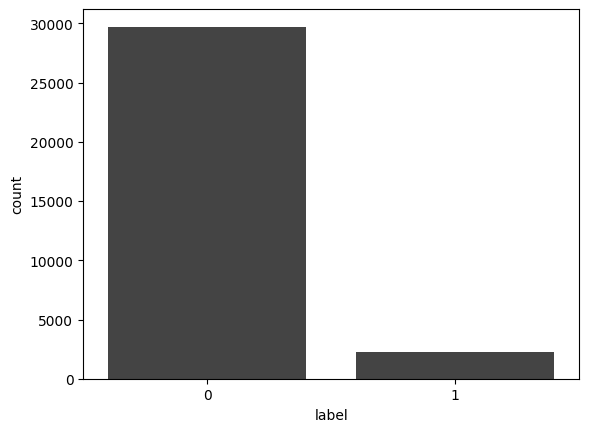

In [12]:
sb.countplot(data=train, x='label',color='#444444');
plt.show()

In [28]:
hate_inices = train.loc[train['label']==1].index

In [56]:
cleaned = train["tweet"].apply(myTokenizer)
clouds = cleaned.apply(lambda x: ' '.join(x))

In [57]:
hate_speech = clouds.loc[clouds.index.isin(hate_inices)]

In [58]:
stops.append('user')
stops.append('users')
stops.append('amp')

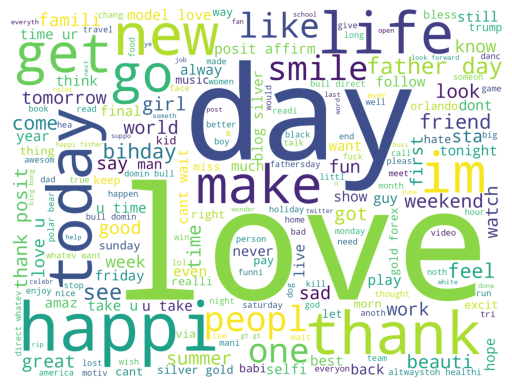

In [53]:
from wordcloud import WordCloud, STOPWORDS

text = " ".join(review for review in cleaned.astype(str))

wordcloud = WordCloud(width = 2000, height = 1500,
                background_color = 'white',
                stopwords = stops,
                min_font_size = 10).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

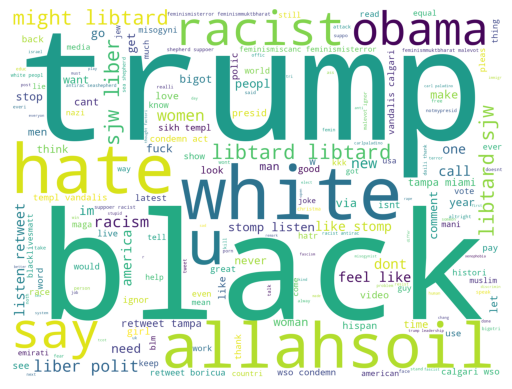

In [54]:
# HATE SPEECH

text = " ".join(review for review in hate_speech.astype(str))

wordcloud = WordCloud(width = 2000, height = 1500,
                background_color = 'white',
                stopwords = stops,
                min_font_size = 10).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [55]:
from gensim.models import Word2Vec
# Build the model
w2v_model = Word2Vec(min_count=5,
                     window=10,
                     vector_size = 1000,
                     sample=5e-5,
                     epochs = 15,
                     alpha=0.025, 
                     min_alpha=0.0007, 
                     negative=20)

In [59]:
w2v_model.build_vocab(cleaned.tolist(), progress_per=10000)

In [62]:
# You can use the generated files to view the embeddings using this url: https://projector.tensorflow.org/
savename = 'Speech'
with open( savename + '_tensors.tsv',  'w+',encoding="utf-8") as tensors:  
    with open ( savename + '_metadata.tsv', 'w+', encoding="utf-8") as metadata:
        for word in w2v_model.wv.index_to_key :
            encoded = word
            metadata.write(encoded + '\n')
            vector_row = '\t'.join(map(str, w2v_model.wv.get_vector(word)))
            tensors.write(vector_row + '\n')

In [37]:
import nltk
nltk.download("punkt")

import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

tokenizer = Tokenizer(nlp.vocab)

from nltk import word_tokenize,sent_tokenize
from nltk.stem  import PorterStemmer


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stops = stopwords.words("english")


def removepunc(my_str): # function to remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
snowstem = SnowballStemmer("english")
portstem = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The tokenizer we're implementing is a function that conducts basic text processing tasks such as converting the text to lowercase, eliminating punctuation, stop words, and numbers. Additionally, it eliminates unnecessary spaces and characters utilizing regex. Prior to utilizing the tokenizer, I manually evaluated its performance on the training dataframe.

In [17]:
def myTokenizer(x):
    return  [snowstem.stem(word.text)for word in 
          tokenizer(removepunc(re.sub(r"\s+\s+"," ",re.sub(r"[^A-Za-z0-9()!?@\'\`\"\r+\r+\n+\n+\b+]"," ",x.lower()))).strip()) 
          if (word.text not in stops and not hasNumbers(word.text)) ]


I am utilizing the torchtext fields and dataset classes to simplify the process of preparing the dataset for the PyTorch model. The most straightforward approach I've discovered for transforming a dataframe into a torchtext dataset is by utilizing the DataFrameDataset class. Please note that this particular cell may require some time to complete its execution.

In [ ]:
TEXT = data.Field(tokenize=myTokenizer,batch_first=True,fix_length=140)
LABEL = data.LabelField(dtype=torch.float ,batch_first=True)


class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('comment_text', text_field), ('toxic', label_field)]
        examples = []
        for i, row in df.iterrows():
            if row['label'] == 0:
                label = 0
            else:
                label = 1
                
            text = row['tweet']
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)
  

torchdataset = DataFrameDataset(train, TEXT,LABEL)

In [ ]:
train_data, valid_data = torchdataset.split(split_ratio=0.8)

TEXT.build_vocab(train_data,min_freq=3)  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

print(len(TEXT.vocab))

Size of TEXT vocabulary: 6810
Size of LABEL vocabulary: 2
[('user', 14147), ('love', 2619), ('day', 2302), (' ', 1867), ('happi', 1694), ('amp', 1421), ('thank', 1252), ('time', 1021), ('get', 1002), ('u', 973)]
6810
